# Deep Learning Project
## Build a Digit Recognition Program

In this project, we will design and implement a deep learning model that learns to recognize sequences of digits. We will train the model using synthetic data generated by concatenating character images from [MNIST](http://yann.lecun.com/exdb/mnist/). 

To produce a synthetic sequence of digits for testing, we will limit the to sequences to up to five digits, and use five classifiers on top of your deep network. We will incorporate an additional ‘blank’ character to account for shorter number sequences.

We will use ** Keras ** to implement the model. You can read more about Keras at [keras.io](https://keras.io/).

### Implementation

Let's start by importing the modules we'll require fot this project.

In [1]:
#Module Imports
from __future__ import print_function
import random
from os import listdir
import glob

import numpy as np
from scipy import misc
import tensorflow as tf
import h5py

from keras.datasets import mnist
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Setting the random seed so that the results are reproducible. 
random.seed(101)

#Setting variables for MNIST image dimensions
mnist_image_height = 28
mnist_image_width = 28

In [3]:
#Import MNIST data from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 11s 1us/step


Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)
Label for image: 5


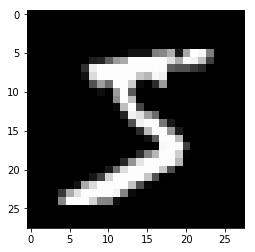

In [4]:
#Checking the downloaded data
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))


plt.figure()
plt.imshow(X_train[0], cmap='gray')

print("Label for image: {}".format(y_train[0]))

### Building synthetic data

The MNIST dataset is very popular for beginner Deep Learning projects. So, to add a twist to the tale, we're going to predict images that can contain 1 to 5 digits. We'll have to change the architecture of our deep learning model for this, but before that, we'll need to generate this dataset first.

To generate the synthetic training data, we will first start by randomly picking out up to 5 individual digits out from the MNIST training set. The individual images will be then stacked together, and blanks will be used to make up the number of digits if there were less than 5. By this approach, we could increase the size of our training data. We'll build around 60,000 such examples.

While concatenating images together, we'll also build the labels for each image. First, labels for single digits will be arranged in tuples of 5. Labels 0-9 will be used for digits 0-9, and a 10 will be used to indicate a blank.

The same approach will be used to build the test data, but using the MNIST test set for individual digits, for 10,000 synthetic test images.



Let's write a function that does this.

In [5]:
def build_synth_data(data,labels,dataset_size):
    
    #Define synthetic image dimensions
    synth_img_height = 64
    synth_img_width = 64
    
    #Define synthetic data
    synth_data = np.ndarray(shape=(dataset_size,synth_img_height,synth_img_width),
                           dtype=np.float32)
    
    #Define synthetic labels
    synth_labels = [] 
    
    #For a loop till the size of the synthetic dataset
    for i in range(0,dataset_size):
        
        #Pick a random number of digits to be in the dataset
        num_digits = random.randint(1,5)
        
        #Randomly sampling indices to extract digits + labels afterwards
        s_indices = [random.randint(0,len(data)-1) for p in range(0,num_digits)]
        
        #stitch images together
        new_image = np.hstack([X_train[index] for index in s_indices])
        #stitch the labels together
        new_label =  [y_train[index] for index in s_indices]
        
        
        #Loop till number of digits - 5, to concatenate blanks images, and blank labels together
        for j in range(0,5-num_digits):
            new_image = np.hstack([new_image,np.zeros(shape=(mnist_image_height,
                                                                   mnist_image_width))])
            new_label.append(10) #Might need to remove this step
        
        #Resize image
        new_image = misc.imresize(new_image,(64,64))
        
        #Assign the image to synth_data
        synth_data[i,:,:] = new_image
        
        #Assign the label to synth_data
        synth_labels.append(tuple(new_label))
        
    
    #Return the synthetic dataset
    return synth_data,synth_labels

In [6]:
#Building the training dataset
X_synth_train,y_synth_train = build_synth_data(X_train,y_train,60000)

/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [7]:
#Building the test dataset
X_synth_test,y_synth_test = build_synth_data(X_test,y_test,10000)

/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 4, 1, 9, 7)

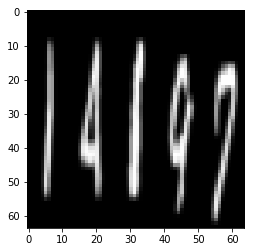

In [8]:
#checking a sample
plt.figure()
plt.imshow(X_synth_train[232], cmap='gray')

y_synth_train[232]

Looks like things work as we expect them to. Let's prepare the datset and labels so that keras can handle them.

### Preparatory Preprocessing

#### Preprocessing Labels for model

The labels are going to be encoded to "One Hot" arrays, to make them compatible with Keras. Note that, as the our Deep Learning model will have 5 classifiers, we'll need 5 such One Hot arrays, one for each digit position in the image. 

In [9]:
#Converting labels to One-hot representations of shape (set_size,digits,classes)
possible_classes = 11

def convert_labels(labels):
    
    #As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    #Each digit array will be of shape (60000,11)
    
    #Code below could be better, but cba for now. 
    
    #Declare output ndarrays
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes)) #5 for digits, 11 for possible classes  
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        #Using np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [10]:
train_labels = convert_labels(y_synth_train)
test_labels = convert_labels(y_synth_test)

In [11]:
#Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(60000, 11)

In [12]:
np_utils.to_categorical(y_synth_train[234][0],11)

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

#### Preprocessing Images for model

The function below will pre-process the images so that they can be handled by keras.

In [13]:
def prep_data_keras(img_data):
    
    #Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data),64,64,1)
    
    #Converting everything to floats
    img_data = img_data.astype('float32')
    
    #Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

In [14]:
train_images = prep_data_keras(X_synth_train)
test_images = prep_data_keras(X_synth_test)

In [15]:
np.shape(train_images)

(60000, 64, 64, 1)

In [16]:
np.shape(test_images)

(10000, 64, 64, 1)

### Model Building

In [ ]:
#Importing relevant keras modules
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

We're going to use a Convolutional Neural Network for our network. 

Starting with a 2D Convolutional layer, we'll use ReLU activations after every Convolutional Layer. 

After the second CovLayer + ReLU, we'll add 2DMaxPooling, and a dropout to make the model robust to overfitting. A flattening layer will be added to make the data ready for classification layers, which were in the form of Dense Layers, of the same size as the no. of classes (11 for us), activated using softmax to give us the probability of each class.

In [ ]:
#Building the model

batch_size = 128
nb_classes = 11
nb_epoch = 12

#image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

#number of convulation filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

#defining the input
inputs = Input(shape=(img_rows,img_cols,img_channels))

#Model taken from keras example. Worked well for a digit, dunno for multiple
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1],border_mode='same')(inputs)
cov = Activation('relu')(cov)
cov = Convolution2D(nb_filters,kernel_size[0],kernel_size[1])(cov)
cov = Activation('relu')(cov)
cov = MaxPooling2D(pool_size=pool_size)(cov)
cov = Dropout(0.25)(cov)
cov_out = Flatten()(cov)


#Dense Layers
cov2 = Dense(128, activation='relu')(cov_out)
cov2 = Dropout(0.5)(cov2)



#Prediction layers
c0 = Dense(nb_classes, activation='softmax')(cov2)
c1 = Dense(nb_classes, activation='softmax')(cov2)
c2 = Dense(nb_classes, activation='softmax')(cov2)
c3 = Dense(nb_classes, activation='softmax')(cov2)
c4 = Dense(nb_classes, activation='softmax')(cov2)

#Defining the model
model = Model(input=inputs,output=[c0,c1,c2,c3,c4])

#Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#Fitting the model
model.fit(train_images,train_labels,batch_size=batch_size,nb_epoch=nb_epoch,verbose=1,
          validation_data=(test_images, test_labels))

/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
/Users/melvynnfernandez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
 1920/60000 [..............................] - ETA: 23:04 - loss: 8.9949 - dense_2_loss: 2.3609 - dense_3_loss: 2.2989 - dense_4_loss: 1.9205 - dense_5_loss: 1.4320 - dense_6_loss: 0.9826 - dense_2_acc: 0.1562 - dense_3_acc: 0.2328 - dense_4_acc: 0.3958 - dense_5_acc: 0.5938 - dense_6_acc: 0.7714

In [ ]:
predictions = model.predict(test_images)

In [ ]:
np.shape(predictions)

In [ ]:
len(predictions[0])

In [ ]:
np.shape(test_labels)

We'll define a custom to calculate accuracy for predicting individual digits, as well as for predicting complete sequence of images.

In [ ]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    for i in range(0,len(predictions[0])):
        #Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter +=1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter/50000.0
    global_accuracy = global_sequence_counter/10000.0
    
    return ind_accuracy,global_accuracy

In [ ]:
ind_acc,glob_acc = calculate_acc(predictions,test_labels)

In [ ]:
print("The individual accuracy is {} %".format(ind_acc*100))
print("The sequence prediction accuracy is {} %".format(glob_acc*100))

In [ ]:
#Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))
    

We can see that model achieved good accuracy, with around 98.5% accurate for identifying individual digits or blanks, and around 92.8% for identifying whole sequences.